# WS10: More support

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.2. For: 22 November, 2023*

In the book, the finite element derivation and implementation of rod extension (the 1D Poisson equation) is presented. In this workshop, you are asked to do the same for a slightly different problem.

## A modification to the PDE: continuous elastic support

<p align="center">
<img src="https://raw.githubusercontent.com/fmeer/public-files/main/barDefinition-2.png" width="400"/>
</p>

For this exercise we still consider a 1D rod. However, now the rod is elastically supported. An example of this would be a foundation pile in soil. 

The problem of an elastically supported rod can be described with the following differential equation:

$$ -EA \frac{\partial^2 u}{\partial x^2} + ku = f $$

with:

$$
u = 0, \quad \text{at} \quad x = 0 \\
EA\frac{\partial u}{{\partial x}} = F, \quad \text{at} \quad x = L
$$

This differential equation is the inhomogeneous Helmholtz equation, which also has applications in dynamics and electromagnetics. The additional term with respect to the case without elastic support is the second term on the left hand side: $ku$. 

The finite element discretized version of this PDE can be obtained following the same steps as shown for the unsupported rod in the book. Note that there are no derivatives in the $ku$ which means that integration by parts does not need to be applied on this term. Using Neumann boundary condition (i.e. an applied load) at $x=L$ and a constant distributed load $f(x)=q$, the following expression is found for the discretized form:

$$\left[\int \mathbf{B}^T EA \mathbf{B} + \mathbf{N}^T k \mathbf{N} \,dx\right]\mathbf{u} = \int \mathbf{N}^T q \,d x + \mathbf{N}^T F \Bigg|_{x=L} $$

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1: Derive the discrete form</b>   

Derive the discrete form of the PDE given above. You can follow the same steps as in the book for the term with $EA$ and the right hand side, but now carrying along the additional term $ku$ from the PDE. Show that this term leads to the $\int\mathbf{N}^Tk\mathbf{N}\,dx$ term in the $\mathbf{K}$-matrix. 
</p>
</div>

***Your derivation here***

## Modification to the FE implementation

The only change with respect to the procedure as implemented in the book is the formulation of the $\mathbf{K}$-matrix, which now consists of two terms:

$$ \mathbf{K} = \int \mathbf{B}^TEA\mathbf{B} + \mathbf{N}^Tk\mathbf{N}\,dx $$

To calculate the integral exactly we must use two integration points.

$$ \mathbf{K_e} = \sum_{i=1}^{n_\mathrm{ip}} \left(\mathbf{B}^T(x_i)EA\mathbf{B}(x_i) + \mathbf{N}^T(x_i) k\mathbf{N}(x_i) \right) w_i$$

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2: Code implementation</b>   

The only change needed with respect to the implementation of the book is in the calculation of the element stiffness matrix. Copy the code from the book and add the term related to the distributed support in the right position. 
    
Use the following parameters: $L=3$ m, $EA=1000$ N, $F=10$ N, $q=0$ N/m (all values are the same as in the book, except for $q$). Additionally, use $k=1000$ N/m$^2$.

Remarks:
<ol>
    <li>The function <code>evaluate_N</code> is already present in the code in the book</li>
    <li>The <code>get_element_matrix</code> function already included a loop over two integration points</li>
    <li>You need to define $k$ somewhere. To allow for varying $k$ as required below, it is convenient to make $k$ a second argument of the <code>simulate</code> function and pass it on to lower level functions from there (cf. how $EA$ is passed on)
</ol>

Check the influence of the distributed support on the solution:
<ol>
    <li>First use $q=0$ N/m and $k=1000$ N/mm$^2$</li>
    <li>Then set $k$ to zero and compare the results</li>
    <li>Does the influence of the supported spring on the solution make sense?</li>
</p>

</div>



In [1]:
def evaluate_N(x_local, dx):
    return np.array([[1-x_local/dx, x_local/dx]])

def evaluate_B(x_local, dx):
    return np.array([[-1/dx, 1/dx]])

def get_element_matrix(EA, k, dx):                  # pass on k
    
    integration_locations = [(dx - dx/(3**0.5))/2, (dx + dx/(3**0.5))/2]

    # The sum of the weights of ALL POINTS (in this case n_ip = 2) should be equal to the LENGTH of the element in 1D. So dx/2 + dx/2 = dx.
    integration_weights = [dx/2, dx/2]              
    n_ip = len(integration_weights)

    n_node = 2
    K_loc = np.zeros((n_node,n_node))

    for x_ip, w_ip in zip(integration_locations, integration_weights):
        B = evaluate_B(x_ip, dx)
        N = evaluate_N(x_ip,dx)                     # new line
        K_loc += EA*np.dot(np.transpose(B), B)*w_ip
        K_loc += k*np.dot(np.transpose(N), N)*w_ip  # new line

    return K_loc

def get_element_force(q, dx):
    n_node = 2
    N = np.zeros((1,n_node))
    
    integration_locations = [(dx - dx/(3**0.5))/2, (dx + dx/(3**0.5))/2]
    integration_weights = [dx/2, dx/2]
    
    f_loc = np.zeros((n_node,1))
    
    for x_ip, w_ip in zip(integration_locations, integration_weights):
        N = evaluate_N(x_ip,dx)
        f_loc += np.transpose(N)*q*w_ip

    return f_loc


def get_nodes_for_element(ie):
    return np.array([ie,ie+1])

def assemble_global_K(rod_length, n_el, k, EA):     # pass on k
    n_DOF = n_el+1
    dx = rod_length/n_el
    K_global = np.zeros((n_DOF, n_DOF))
    
    for i in range(n_el):
        elnodes = get_nodes_for_element(i)
        K_global[np.ix_(elnodes,elnodes)] += get_element_matrix(EA, k, dx)   # pass on k
    
    return K_global

def assemble_global_f(rod_length, n_el, q):
    n_DOF = n_el+1
    dx = rod_length/n_el
    f_global = np.zeros((n_DOF,1))
    
    for i in range(n_el):
        elnodes = get_nodes_for_element(i) 
        f_global[elnodes] += get_element_force(q, dx)
        
    return np.squeeze(f_global)


def simulate(n_element,k):                          # add k as argument
    length = 3
    EA = 1e3
    n_node = n_element + 1
    F_right = 10
    u_left = 0 
    q_load = 0                                      # value changed 

    dx = length/n_element
    x = np.linspace(0,length,n_node)

    K = assemble_global_K(length, n_element, k, EA) # pass on k

    f = assemble_global_f(length, n_element, q_load)

    f[n_node-1] += F_right

    u = np.zeros(n_node)

    f -= K[0,:] * u_left
    K_inv = np.linalg.inv(K[1:n_node, 1:n_node])
    u[1:n_node] = np.dot(K_inv, f[1:n_node])
    u[0] = u_left

    return x, u

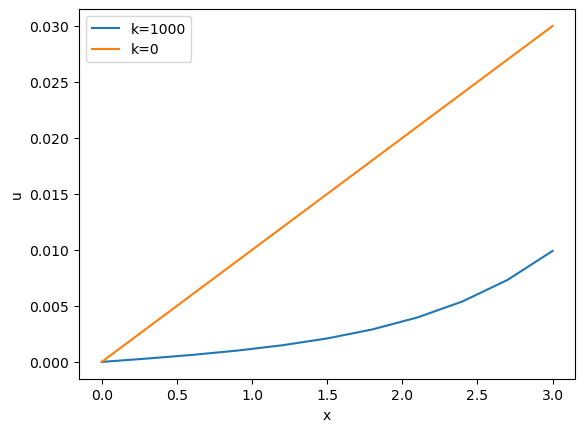

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x10, u_with_k = simulate(10,1000)
x10, u_without_k = simulate(10,0)
plt.figure()
plt.plot(x10, u_with_k, label='k=1000')
plt.plot(x10, u_without_k, label='k=0')
plt.xlabel('x')
plt.ylabel('u')
plt.legend();

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

<b> Task 3: Investigate the influence of discretization on the quality of the solution </b>
<ol>
    <li>How many elements do you need to get a good solution?</li>
    <li>How about when the stiffness of the distributed support is increased to $k=10^6$ N/m$^2$</li>
</p>

</div>

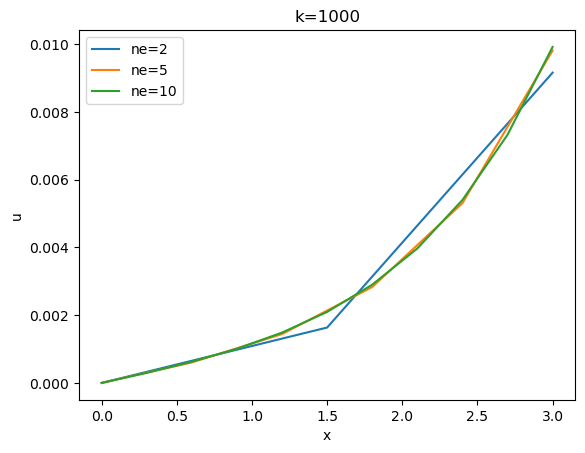

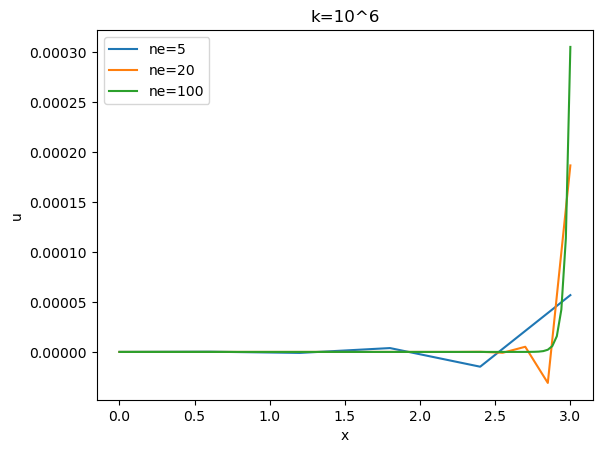

In [3]:
x10, u3_10 = simulate(10, 1.e3)
x5, u3_5 = simulate(5, 1.e3)
x2, u3_2 = simulate(2, 1.e3)
plt.plot(x2, u3_2, label='ne=2')
plt.plot(x5, u3_5, label='ne=5')
plt.plot(x10, u3_10, label='ne=10')
plt.xlabel('x')
plt.ylabel('u')
plt.title('k=1000')
plt.legend();

plt.figure()
x5, u6_5 = simulate(5, 1.e6)
x20, u6_20 = simulate(20, 1.e6)
x100, u6_100 = simulate(100, 1.e6)
plt.plot(x5, u6_5, label='ne=5')
plt.plot(x20, u6_20, label='ne=20')
plt.plot(x100, u6_100, label='ne=100')
plt.xlabel('x')
plt.ylabel('u')
plt.title('k=10^6')
plt.legend();

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.